# Capstone Project - The Battle of Neighborhoods 
# Finding a Better Place to start Ice Cream shops business in Scarborough, Toronto

## Problem Definition
Scarborough is known for its excellent cuisine and its food culture includes an array of international cuisines influenced by the city's immigrant history. Frozen dessert shops have become so popular in Toronto now it seems that there's one on every corner, not only in major cities but also in smaller cities. Starting a frozen dessert shop will be a good business opportunity, but you would like to tell yourself apart from others to enjoy long-term success.
If you intend a frozen dessert shop which will demand higher prices, you need to focus in neighborhoods and outlets that already attract sophisticated clients. If you intend an inexpensive buffet restaurant, point to the masses searching for affordable high-traffic locations with large shopping centers and other local points of interest.

For this analysis, I plan to focus on the Scarborough area, as my father intends to open his business in that borough. We typically define potential neighborhoods based on the number of frozen dessert Shops which are operating right in each neighborhood. Scarborough has full potential but is also a really challenging district to open a business due to high competition. New frozen dessert Shop should be open in a vicinity that's an inadequate neighborhood, so that the shop can attract more customers. Therefore, this analysis is critical to confirm that we would attract enough customers and not very near to other frozen dessert Shops. 


## Import Libraries

In [2]:
#high-level mathematical functions
import numpy as np 
#data manipulation and analysis
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

##  Data Extraction
Built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name

Using BeautifulSoup Scraping, List of Postal Codes of Given Wikipedia Page. 

Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
# To build the code to scrape the following Wikipedia page,
wiki_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

In [4]:
#read the data from url
toronto_df, = pd.read_html(wiki_url, match="Postal Code", skiprows=1)
#The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood (given)
toronto_df.columns = ["PostalCode", "Borough", "Neighborhood"]
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M2A,Not assigned,NaN
1,M3A,North York,Parkwoods
2,M4A,North York,Victoria Village
3,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,M6A,North York,"Lawrence Manor, Lawrence Heights"


## Data Cleaning

In [5]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.(given)
toronto_df = toronto_df[toronto_df["Borough"] != "Not assigned"]
toronto_df.head()

,PostalCode,Borough,Neighborhood
1,M3A,North York,Parkwoods
2,M4A,North York,Victoria Village
3,M5A,Downtown Toronto,"Regent Park, Harbourfront"
4,M6A,North York,"Lawrence Manor, Lawrence Heights"
5,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
borough_fn = lambda b: b.iloc[0]
neighborhood_fn = lambda b: ", ".join(b)
all_fns = {"Borough": borough_fn, "Neighborhood": neighborhood_fn}
temp_toronto_df = toronto_df.groupby(by="PostalCode").aggregate(all_fns)
temp_toronto_df.head()

,Borough,Neighborhood
PostalCode,,
M1B,Scarborough,"Malvern, Rouge"
M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
M1E,Scarborough,"Guildwood, Morningside, West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


In [7]:
toronto_df = temp_toronto_df.reset_index()[toronto_df.columns]
toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
for (j, row) in toronto_df.iterrows():
    if row["Neighborhood"] == "Not assigned":
        borough_each = row["Borough"]
        print("Replace \"Not assigned\" => %s in row %i" % (borough_each, j))
        row["Neighborhood"] = borough_each

In [9]:
#More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: 
#Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
for (j, row) in toronto_df.iterrows():
     row['Neighborhood']=row['Neighborhood'].replace('/',',')

In [10]:
toronto_df.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [11]:
#In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe
toronto_df.shape

(103, 3)

# In order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood

In [12]:
#read csv file (given)
geo_loc_df = pd.read_csv("https://cocl.us/Geospatial_data")
geo_loc_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
#Rename the columns as given format
geo_loc_df.columns = ["PostalCode", "Latitude", "Longitude"]

#Merge both dataframes
toronto_geo_df = pd.merge(toronto_df, geo_loc_df, on='PostalCode')
toronto_geo_df.head(50)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


# Explore and cluster the neighborhoods in Toronto

In [14]:
#Quickly examine the resulting dataframe
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_geo_df['Borough'].unique()),
        toronto_geo_df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [15]:
address = 'Toronto, T.O.'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


# Create a map of Toronto with neighborhoods superimposed on top

In [16]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_geo_df['Latitude'], toronto_geo_df['Longitude'], toronto_geo_df['Borough'], toronto_geo_df['Neighborhood']):
    label = '{}, {}'.format(toronto_geo_df, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [17]:
scarborough_data = toronto_geo_df[toronto_geo_df['Borough'] == 'Scarborough'].reset_index(drop=True)
scarborough_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Explore and cluster the neighborhoods in Scarborough

In [18]:
#Quickly examine the resulting dataframe
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(scarborough_data['Borough'].unique()),
        scarborough_data.shape[0]
    )
)

The dataframe has 1 boroughs and 17 neighborhoods.


In [19]:
address = 'Scarborough, Toronto, ON, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Scarborough are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Scarborough are 43.773077, -79.257774.


In [20]:
# create map of Manhattan using latitude and longitude values
map_scarborough = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(scarborough_data['Latitude'], scarborough_data['Longitude'], scarborough_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_scarborough)  
    
map_scarborough

Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues_iceshop.

In [21]:
import urllib
def getNearbyVenues(post,names, latitude, longitude, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for post,name, lat, lng in zip(post,names, latitude, longitude):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        post,
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['post','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

## Define Foursquare Credentials and Version

In [22]:
LIMIT = 500 
radius = 5000 
CLIENT_ID = '5ZPBJIRPKMQRRXRKE50SHZZNHSUTNK0XBITDQ0QDGVISVATC' # your Foursquare ID
CLIENT_SECRET = 'EELVSM1HLZBC4JS25DFMQPOWJXJVCPO430VHAMCTB4Q24OS0' # your Foursquare Secret
VERSION = '20200430' # Foursquare API version

Get the Foursquare venue details

In [23]:
#https://developer.foursquare.com/docs/resources/categories
#Ice Cream shop = 4bf58dd8d48988d110941735

toronto_geo_df = toronto_geo_df[toronto_geo_df['Borough'] == 'Scarborough'].reset_index(drop=True)
toronto_venues_iceshop = getNearbyVenues(post=toronto_geo_df['PostalCode'],names=toronto_geo_df['Neighborhood'], latitude=toronto_geo_df['Latitude'], longitude=toronto_geo_df['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d1c9941735')
toronto_venues_iceshop.head(10)

,post,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,"Malvern, Rouge",43.806686,-79.194353,McDonald's,43.798261,-79.201449,Fast Food Restaurant
1,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,McDonald's,43.768334,-79.188288,Fast Food Restaurant
2,M1H,Cedarbrae,43.773136,-79.239476,McDonald's,43.780955,-79.234213,Fast Food Restaurant
3,M1J,Scarborough Village,43.744734,-79.239476,Dairy Queen,43.739580,-79.236991,Ice Cream Shop
4,M1J,Scarborough Village,43.744734,-79.239476,Dairy Queen,43.739506,-79.236894,Ice Cream Shop
5,M1J,Scarborough Village,43.744734,-79.239476,McDonald's,43.738985,-79.239869,Fast Food Restaurant
6,M1K,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,McDonald's,43.724591,-79.253462,Fast Food Restaurant
7,M1L,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,Dairy Queen,43.710378,-79.290701,Ice Cream Shop
8,M1L,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,McDonald's,43.709284,-79.295245,Fast Food Restaurant
9,M1L,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,Dairy Queen,43.710296,-79.291126,Ice Cream Shop


Let's check the size of the resulting dataframe

<BarContainer object of 11 artists>

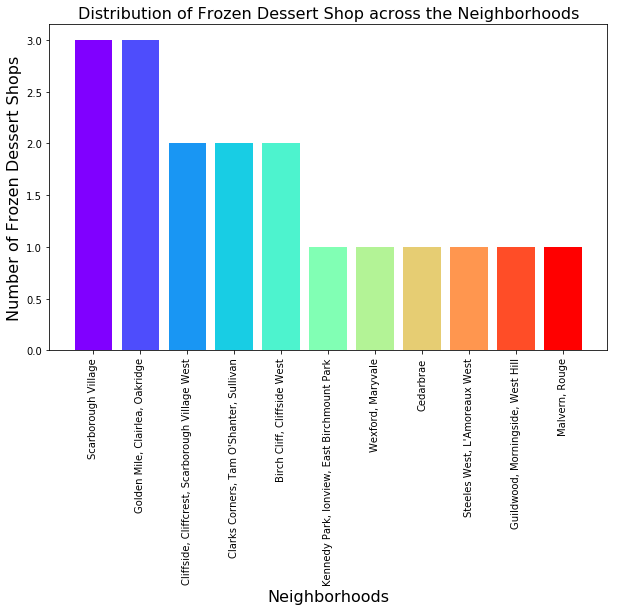

In [24]:
venue_distribution = toronto_venues_iceshop['Neighborhood'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (10, 6))
plt.xticks(rotation = 90)
plt.xlabel("Neighborhoods", fontsize = 16)
plt.ylabel("Number of Frozen Dessert Shops", fontsize = 16)
plt.title("Distribution of Frozen Dessert Shop across the Neighborhoods", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

And how many venues were returned by Foursquare?

In [25]:
print('{} venues were returned by Foursquare.'.format(toronto_venues_iceshop.shape[0]))

18 venues were returned by Foursquare.


In [26]:
toronto_venues_iceshop=toronto_venues_iceshop.drop(['post'], axis=1)

In [27]:
toronto_venues_iceshop

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,McDonald's,43.798261,-79.201449,Fast Food Restaurant
1,"Guildwood, Morningside, West Hill",43.763573,-79.188711,McDonald's,43.768334,-79.188288,Fast Food Restaurant
2,Cedarbrae,43.773136,-79.239476,McDonald's,43.780955,-79.234213,Fast Food Restaurant
3,Scarborough Village,43.744734,-79.239476,Dairy Queen,43.739580,-79.236991,Ice Cream Shop
4,Scarborough Village,43.744734,-79.239476,Dairy Queen,43.739506,-79.236894,Ice Cream Shop
5,Scarborough Village,43.744734,-79.239476,McDonald's,43.738985,-79.239869,Fast Food Restaurant
6,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,McDonald's,43.724591,-79.253462,Fast Food Restaurant
7,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,Dairy Queen,43.710378,-79.290701,Ice Cream Shop
8,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,McDonald's,43.709284,-79.295245,Fast Food Restaurant
9,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,Dairy Queen,43.710296,-79.291126,Ice Cream Shop


## Venues were returned by Foursquare

Let's create a function to repeat the same process to all the neighborhoods in Scarborough

In [28]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

## Map to display Scarborough - Venues were returned by Foursquare

In [29]:
map_toronto_iceshop = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(toronto_venues_iceshop, 'red', map_toronto_iceshop)

map_toronto_iceshop

In [30]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

Let's check how many venues were returned for each neighborhood

In [31]:
torontto_grouped = toronto_venues_iceshop.groupby('Neighborhood').count()
torontto_grouped

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Birch Cliff, Cliffside West",2,2,2,2,2,2
Cedarbrae,1,1,1,1,1,1
"Clarks Corners, Tam O'Shanter, Sullivan",2,2,2,2,2,2
"Cliffside, Cliffcrest, Scarborough Village West",2,2,2,2,2,2
"Golden Mile, Clairlea, Oakridge",3,3,3,3,3,3
"Guildwood, Morningside, West Hill",1,1,1,1,1,1
"Kennedy Park, Ionview, East Birchmount Park",1,1,1,1,1,1
"Malvern, Rouge",1,1,1,1,1,1
Scarborough Village,3,3,3,3,3,3


## Analyze Each Neighborhood

In [32]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_iceshop[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_iceshop['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot

,Neighborhood,Fast Food Restaurant,Ice Cream Shop
0,"Malvern, Rouge",1,0
1,"Guildwood, Morningside, West Hill",1,0
2,Cedarbrae,1,0
3,Scarborough Village,0,1
4,Scarborough Village,0,1
5,Scarborough Village,1,0
6,"Kennedy Park, Ionview, East Birchmount Park",1,0
7,"Golden Mile, Clairlea, Oakridge",0,1
8,"Golden Mile, Clairlea, Oakridge",1,0
9,"Golden Mile, Clairlea, Oakridge",0,1


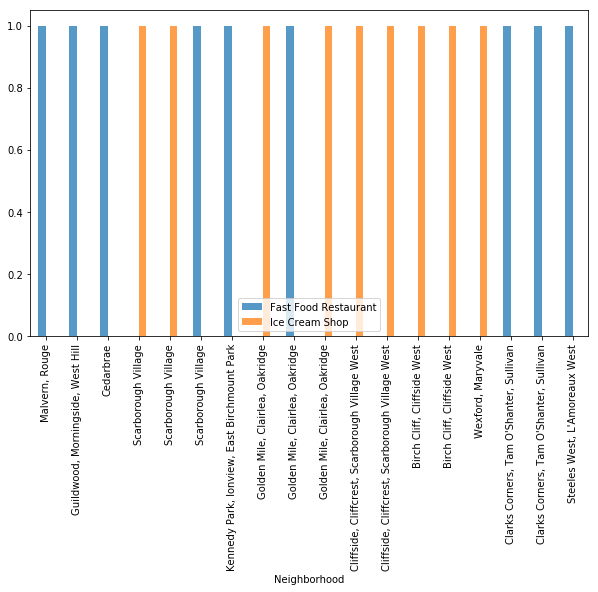

In [33]:
#plt.figure(figsize = (10, 6))
#plt.xticks(rotation = 90)
#plt.xlabel("Neighborhoods", fontsize = 16)
#plt.ylabel("Number of Frozen Dessert Shops", fontsize = 16)
#plt.title("Distribution of Frozen Dessert Shop across the Neighborhoods", fontsize = 16)
#plt.bar(venue_distribution.index, venue_distribution.values, color = colors)
toronto_onehot.plot(x='Neighborhood',y=['Fast Food Restaurant','Ice Cream Shop'],kind='bar',figsize=(10,6),alpha=0.75)
#xlabel("Neighborhood", fontsize = 16)

And let's examine the new dataframe size.

In [34]:
toronto_onehot.shape

(18, 3)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [35]:
toronnto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronnto_grouped

,Neighborhood,Fast Food Restaurant,Ice Cream Shop
0,"Birch Cliff, Cliffside West",0.000000,1.000000
1,Cedarbrae,1.000000,0.000000
2,"Clarks Corners, Tam O'Shanter, Sullivan",1.000000,0.000000
3,"Cliffside, Cliffcrest, Scarborough Village West",0.000000,1.000000
4,"Golden Mile, Clairlea, Oakridge",0.333333,0.666667
5,"Guildwood, Morningside, West Hill",1.000000,0.000000
6,"Kennedy Park, Ionview, East Birchmount Park",1.000000,0.000000
7,"Malvern, Rouge",1.000000,0.000000
8,Scarborough Village,0.333333,0.666667
9,"Steeles West, L'Amoreaux West",1.000000,0.000000


Let's confirm the new size

In [36]:
toronnto_grouped.shape

(11, 3)

Find optimal k for the clustering process

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/clu

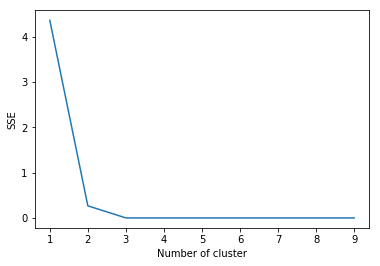

In [37]:
city_grouped_clustering = toronnto_grouped.drop('Neighborhood', 1)

sse = {}
for k in range(1, 10):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0,max_iter = 1000).fit(city_grouped_clustering)
    city_grouped_clustering["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's print each neighborhood along with the top 2 most common venues

In [39]:
num_top_venues = 2

indicators = ['st', 'nd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronnto_grouped['Neighborhood']

for ind in np.arange(toronnto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronnto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue
0,"Birch Cliff, Cliffside West",Ice Cream Shop,Fast Food Restaurant
1,Cedarbrae,Fast Food Restaurant,Ice Cream Shop
2,"Clarks Corners, Tam O'Shanter, Sullivan",Fast Food Restaurant,Ice Cream Shop
3,"Cliffside, Cliffcrest, Scarborough Village West",Ice Cream Shop,Fast Food Restaurant
4,"Golden Mile, Clairlea, Oakridge",Ice Cream Shop,Fast Food Restaurant


## Cluster Neighborhoods

Run k-means to cluster the neighborhood into 3 clusters.

In [40]:
# set number of clusters
kclusters = 3

toronnto_grouped_clustering = toronnto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronnto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 1, 2, 0, 0, 0, 2, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_venues_iceshop
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
0,"Malvern, Rouge",43.806686,-79.194353,McDonald's,43.798261,-79.201449,Fast Food Restaurant,0,Fast Food Restaurant,Ice Cream Shop
1,"Guildwood, Morningside, West Hill",43.763573,-79.188711,McDonald's,43.768334,-79.188288,Fast Food Restaurant,0,Fast Food Restaurant,Ice Cream Shop
2,Cedarbrae,43.773136,-79.239476,McDonald's,43.780955,-79.234213,Fast Food Restaurant,0,Fast Food Restaurant,Ice Cream Shop
3,Scarborough Village,43.744734,-79.239476,Dairy Queen,43.739580,-79.236991,Ice Cream Shop,2,Ice Cream Shop,Fast Food Restaurant
4,Scarborough Village,43.744734,-79.239476,Dairy Queen,43.739506,-79.236894,Ice Cream Shop,2,Ice Cream Shop,Fast Food Restaurant


Finally, let's visualize the resulting clusters

In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['#FF0000','#FFFF00','#0000FF']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        color=rainbow[cluster-1],
        fill=True,
       fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### Cluster 1

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
0,43.806686,-79.201449,Fast Food Restaurant,0,Fast Food Restaurant,Ice Cream Shop
1,43.763573,-79.188288,Fast Food Restaurant,0,Fast Food Restaurant,Ice Cream Shop
2,43.773136,-79.234213,Fast Food Restaurant,0,Fast Food Restaurant,Ice Cream Shop
6,43.727929,-79.253462,Fast Food Restaurant,0,Fast Food Restaurant,Ice Cream Shop
15,43.781638,-79.308865,Fast Food Restaurant,0,Fast Food Restaurant,Ice Cream Shop
16,43.781638,-79.291267,Fast Food Restaurant,0,Fast Food Restaurant,Ice Cream Shop
17,43.799525,-79.318167,Fast Food Restaurant,0,Fast Food Restaurant,Ice Cream Shop


### Cluster 2

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
10,43.716316,-79.235452,Ice Cream Shop,1,Ice Cream Shop,Fast Food Restaurant
11,43.716316,-79.235625,Ice Cream Shop,1,Ice Cream Shop,Fast Food Restaurant
12,43.692657,-79.276998,Ice Cream Shop,1,Ice Cream Shop,Fast Food Restaurant
13,43.692657,-79.276477,Ice Cream Shop,1,Ice Cream Shop,Fast Food Restaurant
14,43.750072,-79.297850,Ice Cream Shop,1,Ice Cream Shop,Fast Food Restaurant


### Cluster 3

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue
3,43.744734,-79.236991,Ice Cream Shop,2,Ice Cream Shop,Fast Food Restaurant
4,43.744734,-79.236894,Ice Cream Shop,2,Ice Cream Shop,Fast Food Restaurant
5,43.744734,-79.239869,Fast Food Restaurant,2,Ice Cream Shop,Fast Food Restaurant
7,43.711112,-79.290701,Ice Cream Shop,2,Ice Cream Shop,Fast Food Restaurant
8,43.711112,-79.295245,Fast Food Restaurant,2,Ice Cream Shop,Fast Food Restaurant
9,43.711112,-79.291126,Ice Cream Shop,2,Ice Cream Shop,Fast Food Restaurant
